# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.32 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

single_agent = False
if single_agent:
    # select this option to load version 1 (with a single agent) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
else:
    # select this option to load version 2 (with 20 agents) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0669999985024333


In [6]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim


def reset_parameters(layers):
    for ith_layer in range(0, len(layers) - 1):
        layer = layers[ith_layer]
        layer.weight.data.uniform_(*hidden_init(layer))
    layers[-1].weight.data.uniform_(-3e-3, 3e-3)


class Model(nn.Module):
    """ The abstract Model """
    def __init__(self, name, state_size, action_size, random_seed, *args):
        """ Initialise model parameters
            :param name: Specifies the name of the model (for convenience)
            :param state_size: Dimension of the state space of an environment
            :param action_size: Dimension of the action space of an environment
            :param random_seed: Random seed
            :param args: Sizes of hidden layers
         """
        if len(args) == 0:
            raise ValueError("Hidden layer units not specified")
        super(Model, self).__init__()
        torch.manual_seed(random_seed)
        self.state_size = state_size
        self.action_size = action_size
        self.name = name

    
    def forward(self, state, action=None):
        pass

    def print_(self):
        print("Initialised '{}' model".format(self.name))


class Actor(Model):
    def __init__(self, name, state_size, action_size, random_seed, fc1_units=256, fc2_units=128):
        """
        Initialise Actor model (policy gradient function)
        :param fc1_units: Nodes in 1st hidden layer
        :param fc2_units: Nodes in 2nd hidden layer
        """
        super().__init__(name, state_size, action_size, random_seed, fc1_units, fc2_units)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        reset_parameters([self.fc1, self.fc2, self.fc3])
        self.print_()

    def forward(self, state, action=None):
        """ Perform forward pass and map state to action """
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        return torch.tanh(self.fc3(state))


class Critic(Model):
    def __init__(self, name, state_size, action_size, random_seed, fc1_units=256, fc2_units=128):
        """
        Initialise Critic model (value based function)
        :param fc1_units: Nodes in 1st hidden layer
        :param fc2_units: Nodes in 2nd hidden layer
        """
        super().__init__(name, state_size, action_size, random_seed, fc1_units, fc2_units)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        reset_parameters([self.fc1, self.fc2, self.fc3])
        self.print_()

    def forward(self, state, action=None):
        """ Perform forward pass and map state and action to Q values """
        assert action is not None, "Action cannot be none"
        xs = F.leaky_relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

In [7]:


import copy


class ActionNoise:
    def reset(self):
        pass


class OUNoise(ActionNoise):
    """ Ornstein-Uhlenbeck exploration noise process for temporally correlated noise """

    def __init__(self, action_size, seed, mu=0., theta=.15, sigma=.2):
        self.mu = mu * np.ones(action_size)
        self.theta = theta
        self.sigma = sigma
        self.state = None
        self.action_size = action_size
        random.seed(seed)

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.action_size)
        self.state = x + dx
        return self.state


class AdaptiveNoise(ActionNoise):
    """ Adds adaptive noise to the parameters of the neural network policy - allows for quicker training
        For more details, see: https://openai.com/blog/better-exploration-with-parameter-noise/
     """
    def __init__(self, initial_stddev=.1, desired_action_stddev=.1, adoption_coefficient=1.01):
        self.initial_stddev = initial_stddev
        self.desired_action_stddev = desired_action_stddev
        self.adoption_coefficient = adoption_coefficient
        self.current_stddev = initial_stddev

    def adapt(self, distance):
        if distance > self.desired_action_stddev:
            self.current_stddev /= self.adoption_coefficient  # decrease standard deviation
        else:
            self.current_stddev *= self.adoption_coefficient  # increase standard deviation

In [8]:
from collections import deque, namedtuple



class Experience:
    """ Helper class to encapsulate an experience """

    def __init__(self, state, action, reward, next_state, done):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.done = done

    def get_state(self):
        return self.state

    def get_action(self):
        return self.action

    def get_reward(self):
        return self.reward

    def get_next_state(self):
        return self.next_state

    def get_done(self):
        return self.done


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size: int, buffer_size: int, batch_size: int, random_seed: int):
        """ Initialize a ReplayBuffer object.
            :param buffer_size (int): maximum size of buffer
            :param batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        random.seed(random_seed)

    def add(self, experience: Experience):
        """Add a new experience to memory."""
        e = self.experience(experience.get_state(), experience.get_action(), experience.get_reward(),
                            experience.get_next_state(), experience.get_done())
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            DEVICE)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
from torch import optim



ACTOR_LR = 1e-4
CRITIC_LR = 1e-4
WEIGHT_DECAY = 0
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128  # minibatch size
GAMMA = .99
TAU = 1e-3




DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def minimize_loss(loss, optimizer: optim.Adam, is_critic=False, critic=None):
    optimizer.zero_grad()
    loss.backward()
    if is_critic and critic is not None:
        torch.nn.utils.clip_grad_norm_(critic.parameters(), 1)
    optimizer.step()


def soft_update(local_model, target_model):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model: PyTorch model (weights will be copied from)
        target_model: PyTorch model (weights will be copied to)
        tau (float): interpolation parameter
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(TAU * local_param.data + (1.0 - TAU) * target_param.data)


class ContinuousControlAgent:
    """ The agent that learns to interact with an environment using the DDPG algorithm """
    def __init__(self, state_size, action_size, random_seed, memory: ReplayBuffer, update_frequency=10):
        """
        Initialise the agent
        :param state_size: Dimension of the state space
        :param action_size: Dimension of the action space
        :param random_seed: Random seed
        """
        random.seed(random_seed)

        self.time_step = 0
        self.update_frequency = update_frequency

        # Initialise the Actor networks (local and target), including the Optimizer
        self.actor_local = Actor("Actor: Local", state_size, action_size, random_seed).to(DEVICE)
        self.actor_target = Actor("Actor: Target", state_size, action_size, random_seed).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=ACTOR_LR)

        # Initialise the Critic networks (local and target)
        self.critic_local = Critic("Critic: Local", state_size, action_size, random_seed).to(DEVICE)
        self.critic_target = Critic("Critic: Target", state_size, action_size, random_seed).to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=CRITIC_LR,
                                           weight_decay=WEIGHT_DECAY)

        # Exploration noise process
        self.noise = OUNoise(action_size, 0)

        # Replay buffer
        self.memory = memory

        self.ready_to_learn = len(self.memory) > BATCH_SIZE

    def reset(self):
        self.noise.reset()

    def act(self, state, add_noise=True):
        """ Return the action for the state as per the policy """
        state = torch.from_numpy(state).float().to(DEVICE)
        self.actor_local.eval()  # put the policy in evaluation mode
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()  # put policy back in training mode
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def step(self, experience: Experience):
        """ Add experiences to the experience buffer and learn from a batch """
        self.memory.add(experience)
        if not self.ready_to_learn:
            if len(self.memory) % (BATCH_SIZE // 4) == 0:
                print("Agent experiences collected {}, agent requires  {}"
                      " experiences".format(len(self.memory), BATCH_SIZE))
            self.ready_to_learn = len(self.memory) > BATCH_SIZE

        self.time_step = (self.time_step + 1) % self.update_frequency
        if self.time_step == 0:
            if self.ready_to_learn:
                experiences = self.memory.sample()
                self.learn_(experiences)

    def local_actor_network(self):
        return self.actor_local

    def learn_(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        actions_next = self.actor_target(next_states)
        q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i) - Check https://arxiv.org/pdf/1509.02971.pdf paper
        q_targets = rewards + (GAMMA * q_targets_next * (1 - dones))
        # compute critic loss
        q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(q_expected, q_targets)
        minimize_loss(critic_loss, self.critic_optimizer, is_critic=True, critic=self.critic_local)

        # update the actor
        actions_predicted = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_predicted).mean()
        minimize_loss(actor_loss, self.actor_optimizer)

        # update target networks
        soft_update(self.critic_local, self.critic_target)
        soft_update(self.actor_local, self.actor_target)

In [11]:
def step_tuple(env_info):
    """ Returns a tuple of next state, reward, and done when the agent steps through the environment based
        on the action taken
        :param env_info: Object holding information about the environment at a certain point
    """
    if single_agent:
        return env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
    return env_info.vector_observations, env_info.rewards, env_info.local_done




def ddpg(agent: ContinuousControlAgent, env: UnityEnvironment, num_episodes=2000, target=30., max_time_steps=500,
         saved_model="checkpoint.pth"):
    """ Train an agent using the DDPG algorithm

        :param agent: a continuous control agent
        :param env: environment the agent interacts with
        :param num_episodes: the number of episodes to train the agent
        :param target: The average target score the agent needs to achieve for optimal performance
        :param max_time_steps: Maximum time steps per episode
        :param saved_model: The file path to save the model weights
    """
    now = datetime.datetime.now()
    print(now, "- Training {}".format("single agent" if single_agent else "{} agents".format(20))
          + " for max {} episodes. Target score to reach is {}".format(num_episodes, target))
    # collections to help keep track of the score
    scores_deque = deque(maxlen=100)
    scores = []
    stats = {"scores": [], "episodes": []}  # collects stats for plotting purposes
    mean_score = 0.

    for episode in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations[0] if single_agent else env_info.vector_observations
        agent.reset()                                                # reset the agent noise
        score = 0 if single_agent else np.zeros(num_agents)

        for _ in range(max_time_steps):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states, rewards, dones = step_tuple(env_info)
            if single_agent:
                agent.step(Experience(states, actions, rewards, next_states, dones))
            else:
                for idx in random.sample(range(num_agents), 10):
                    agent.step(Experience(states[idx], actions[idx], rewards[idx], next_states[idx], dones[idx]))
            states = next_states
            score += rewards
            if np.any(dones):
                break
        scores_deque.append(score)
        scores.append(score)
        mean_score = np.mean(scores_deque)

        print('\r---{}---Episode {}\tAverage Score: {:.2f}'.format(now,episode, mean_score), end="")
        if episode % 100 == 0:
            print('\r---{}---Episode {}\tAverage Score: {:.2f}'.format(now,episode, mean_score))

        stats["scores"].append(score if single_agent else np.mean(score))
        stats["episodes"].append(episode)

        if mean_score >= target:
            print('\n---{}---Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(now,episode, mean_score))
            print("Target score of {0} has been reached. Saving model to {1}".format(now, target, saved_model))
            torch.save(agent.local_actor_network().state_dict(), saved_model)
            break

    now = datetime.datetime.now()
    print(now, "- Finished training " + "successfully!" if mean_score >= target else "unsuccessfully!")
    return scores, stats

def plot(stats):
    scores = stats["scores"]
    episodes = stats["episodes"]
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.plot(episodes, scores)
    fig = plt.figure()
    plt.show()

def run(agent_: ContinuousControlAgent, env_: UnityEnvironment, num_episodes=2000, max_time_steps=1000, target=30.,
        saved_model):

        scores, stats= ddpg(agent_, env_, num_episodes=num_episodes, target=target, max_time_steps=max_time_steps,
                        saved_model=saved_model)
        plot(stats)
        return scores, stats


 

Initialised 'Actor: Local' model
Initialised 'Actor: Target' model
Initialised 'Critic: Local' model
Initialised 'Critic: Target' model
2022-11-19 13:51:34.212906 - Training 20 agents for max 3000 episodes. Target score to reach is 30.0
Agent experiences collected 32, agent requires  128 experiences
Agent experiences collected 64, agent requires  128 experiences
Agent experiences collected 96, agent requires  128 experiences
Agent experiences collected 128, agent requires  128 experiences
---2022-11-19 13:51:34.212906---Episode 69	Average Score: 30.07
---2022-11-19 13:51:34.212906---Environment solved in 69 episodes!	Average Score: 30.07
Target score of 2022-11-19 13:51:34.212906 has been reached. Saving model to 30.0
2022-11-19 15:27:15.418694 - Finished training successfully!


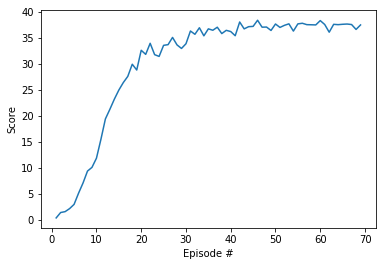

TypeError: 'NoneType' object is not iterable

In [12]:
memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed=0)
agent = ContinuousControlAgent(state_size, action_size, 0, memory=memory, update_frequency=2)
stats = None
saved_model = 'checkpoint_multi.pth'

scores, stats = run(agent, env, num_episodes=3000, max_time_steps=1000, target=30., saved_model=saved_model)

In [ ]:
#env.close()

In [23]:
stats